In [17]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import partipy
import os
% matplotlib notebook


In [2]:
# lets create a modflow model

In [3]:
name = 'mymodel'
model_ws = os.path.join('data')
exe = os.path.join('gw_codes','mf2k.exe')
if not os.path.exists(model_ws): os.mkdir(model_ws)
mf = flopy.modflow.Modflow(name,version='mf2k',model_ws=model_ws,exe_name=exe)

In [4]:
nlay = 1
nrow, ncol = 400,400
delr, delc = 10., 10.
Lx = ncol*delr
Ly = nrow*delc
top = 200
botm = 0
steady= True
nper = 10
perlen = 365


In [5]:
dis = flopy.modflow.ModflowDis(mf,nlay,nrow,ncol,top=top,botm=botm,steady=steady,delr=delr,delc=delc,nper=nper,perlen=perlen)

In [6]:
ibound = np.ones((nlay, nrow, ncol))
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
start = np.ones((nlay,nrow,ncol)) * 197
h1, h2 = 200, 196.735
start[:, :, 0] = h1
start[:, :,-1] = h2

In [7]:
bas = flopy.modflow.ModflowBas(mf,ibound,strt=start)

In [8]:
#LPF change hydraulic conductivity here
hk = 10
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=10., ipakcb=53)

#OC
spd = {} # slight change to oc so we can save heads and budget for all stress periods
for sp in range(nper):
    spd[(sp, 0)] = ['print head', 'print budget', 'save head', 'save budget']
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
#, extension=['oc', 'hds', 'ddn', 'cbb', 'ibo']

#PCG
#I've seen examples of all three solvers being used
pcg = flopy.modflow.ModflowPcg(mf)

In [9]:
Qgpm = -2.5
Qcfd = Qgpm * 192.5
wel = flopy.modflow.ModflowWel(mf,stress_period_data={1:[0,200,300,Qcfd]})

In [10]:
mf.write_input()
mf.run_model(silent=False)

FloPy is using the following executable to run the model: gw_codes\mf2k.exe

                                 MODFLOW-2000
   U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                            Version 1.18.00 08/23/2007                      

Using NAME file: mymodel.nam                                                                                                                                                                                             
Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/08/08 14:12:43

Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/08/08 14:12:46
Elapsed run time:  3.144 Seconds

Normal termination of MODFLOW-2000


(True, [])

In [11]:
import fetter

ymax = fetter.ymax_uc(Qcfd,hk,h1,h2,Lx)

Qcfd = 2.5 * 192.5
xstag = fetter.stag_dist_uc(Qcfd,hk,h1,h2,Lx)

y = fetter.get_y_vals(ymax)
y = np.array(y)
x = fetter.make_shape_uc(y,Qcfd,hk,h1,h2,Lx)
print(ymax,xstag,x[0])

148.60965726154825 47.303923088735566 -4318.30598755187


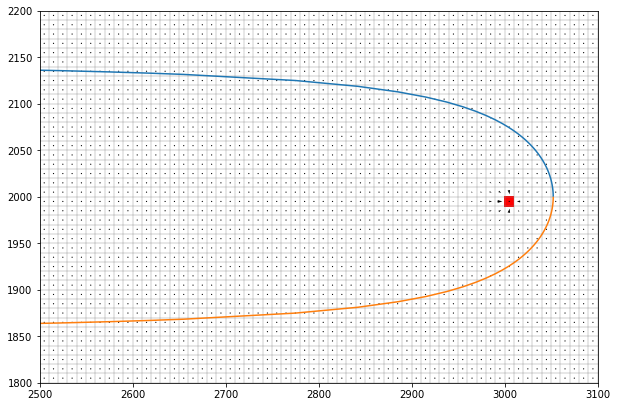

In [12]:
import flopy.utils.binaryfile as bf

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

hds = bf.HeadFile(os.path.join(model_ws,name+'.hds'))
times = hds.get_times()
head = hds.get_data(totim=times[-1])
levels = np.linspace(0, 10, 11)

cbb = bf.CellBudgetFile(os.path.join(model_ws,name+'.cbc'))
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

modelmap = flopy.plot.ModelMap(model=mf, layer=0)
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid(alpha=.25)
# cs = modelmap.contour_array(head, levels=levels)
bc = modelmap.plot_bc('wel',color='r',kper=1)
quiver = modelmap.plot_discharge(frf, fff, head=head)
ax.set_ylim([1800,2200])
ax.set_xlim([2500,3100])
ax.plot(x+3005,y+2000)
ax.plot(x+3005,-y+2000)

In [13]:
# now time to parti

In [29]:
starting_locs = [(0,2145),(0,2141)]

tp = partipy.track_particles(os.path.join(name+'.cbc'),model_ws,name,starting_locs,n=.3,delt=200,ntimes = 1000)
particles = tp.rk4() # this can take some time 

H:\Miniconda3\lib\site-packages\partipy\partipy.py:69: RuntimeWarning: divide by zero encountered in double_scalars
  snk = Qsnk/Qin


<IPython.core.display.Javascript object>


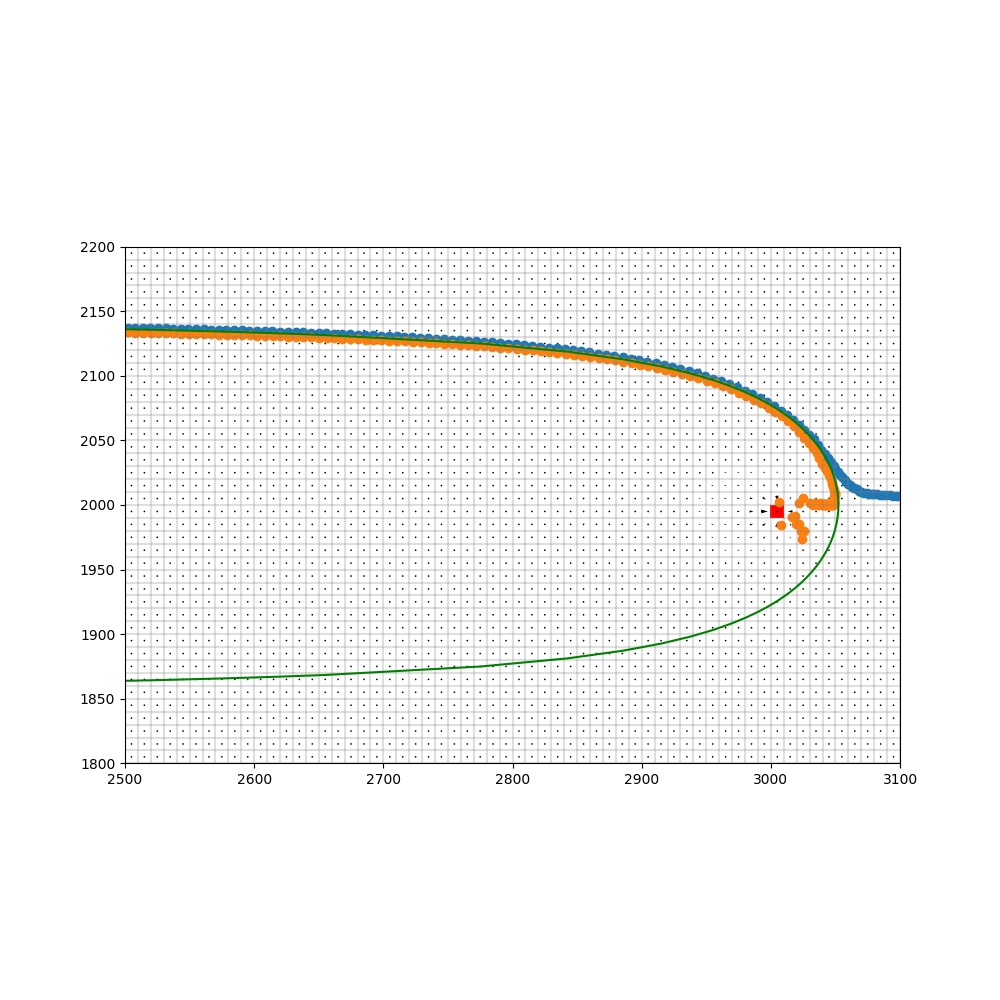

0
1


In [30]:
import flopy.utils.binaryfile as bf

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

hds = bf.HeadFile(os.path.join(model_ws,name+'.hds'))
times = hds.get_times()
head = hds.get_data(totim=times[-1])
levels = np.linspace(0, 10, 11)

cbb = bf.CellBudgetFile(os.path.join(model_ws,name+'.cbc'))
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

modelmap = flopy.plot.ModelMap(model=mf, layer=0)
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid(alpha=.25)
# cs = modelmap.contour_array(head, levels=levels)
bc = modelmap.plot_bc('wel',color='r',kper=1)
quiver = modelmap.plot_discharge(frf, fff, head=head)
ax.set_ylim([1800,2200])
ax.set_xlim([2500,3100])
ax.plot(x+3005,y+2000,color='g')
ax.plot(x+3005,-y+2000,color='g')
for p in particles.keys():
    print(p)
    px, py = particles[p][0], particles[p][1]
    ax.scatter(px,py)
